## Covid-19 Numbers Extraction, EDA & Forecasting

### Problem Statement

**Gain better understanding of the Covid-19 pandemic by diving deeper into case numbers - confirmed, recovered and fatal cases, most affected countries and cities as well as mortality rates among cities and countries. From there, use a timeseries recurring neural-net model - LSTM to forecast the absolute number of confirmed and fatal cases for the next 7 days. The model is measured through MAPE (Mean Absolute Percentage Error and RMSLE).** 

In [1]:
# imports
import os
import re
import datetime 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_log_error

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
## read csv dataset
covid19 = pd.read_csv('../datasets/covid/covid_19_data.csv')
covid19.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
17367,17368,04/21/2020,Wyoming,US,2020-04-21 23:39:09,443.0,2.0,0.0
17368,17369,04/21/2020,Xinjiang,Mainland China,2020-04-21 23:39:09,76.0,3.0,73.0
17369,17370,04/21/2020,Yukon,Canada,2020-04-21 23:39:09,11.0,0.0,0.0
17370,17371,04/21/2020,Yunnan,Mainland China,2020-04-21 23:39:09,184.0,2.0,178.0
17371,17372,04/21/2020,Zhejiang,Mainland China,2020-04-21 23:39:09,1268.0,1.0,1251.0


In [3]:
covid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12889 entries, 0 to 12888
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              12889 non-null  int64  
 1   ObservationDate  12889 non-null  object 
 2   Province/State   6687 non-null   object 
 3   Country/Region   12889 non-null  object 
 4   Last Update      12889 non-null  object 
 5   Confirmed        12889 non-null  float64
 6   Deaths           12889 non-null  float64
 7   Recovered        12889 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 805.7+ KB


In [4]:
# rename columns
covid19.columns = covid19.columns.map(lambda x: x.replace(' ', '_'))
covid19.columns = covid19.columns.map(lambda x: x.replace('/', '_'))
covid19.columns = covid19.columns.map(lambda x: x.lower())
covid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12889 entries, 0 to 12888
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sno              12889 non-null  int64  
 1   observationdate  12889 non-null  object 
 2   province_state   6687 non-null   object 
 3   country_region   12889 non-null  object 
 4   last_update      12889 non-null  object 
 5   confirmed        12889 non-null  float64
 6   deaths           12889 non-null  float64
 7   recovered        12889 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 805.7+ KB


In [5]:
# dropping irrelevant columns
covid19.drop(['sno','last_update'], axis = 1, inplace = True)
covid19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12889 entries, 0 to 12888
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   observationdate  12889 non-null  object 
 1   province_state   6687 non-null   object 
 2   country_region   12889 non-null  object 
 3   confirmed        12889 non-null  float64
 4   deaths           12889 non-null  float64
 5   recovered        12889 non-null  float64
dtypes: float64(3), object(3)
memory usage: 604.3+ KB


In [6]:
duplicate_rows=covid19.duplicated()
covid19[duplicate_rows == True]

,observationdate,province_state,country_region,confirmed,deaths,recovered


In [7]:
covid19[covid19['province_state'] == 'Alaska'].sort_values(by = 'observationdate')

,observationdate,province_state,country_region,confirmed,deaths,recovered
4706,03/10/2020,Alaska,US,0.0,0.0,0.0
4927,03/11/2020,Alaska,US,0.0,0.0,0.0
5148,03/12/2020,Alaska,US,0.0,0.0,0.0
5325,03/13/2020,Alaska,US,1.0,0.0,0.0
5882,03/15/2020,Alaska,US,1.0,0.0,0.0
6154,03/16/2020,Alaska,US,1.0,0.0,0.0
6391,03/17/2020,Alaska,US,3.0,0.0,0.0
6654,03/18/2020,Alaska,US,6.0,0.0,0.0
6936,03/19/2020,Alaska,US,9.0,0.0,0.0
7227,03/20/2020,Alaska,US,12.0,0.0,0.0


In [8]:
country_list=list(covid19['country_region'].unique())
print(country_list)
print (len(country_list))

['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan', 'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia', 'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France', 'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast', 'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt', 'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia', 'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands', 'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania', 'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic', 'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Saint Barthelemy', 

In [9]:
print(list(covid19['observationdate'].unique()))
print(len(list(covid19['observationdate'].unique())))

['01/22/2020', '01/23/2020', '01/24/2020', '01/25/2020', '01/26/2020', '01/27/2020', '01/28/2020', '01/29/2020', '01/30/2020', '01/31/2020', '02/01/2020', '02/02/2020', '02/03/2020', '02/04/2020', '02/05/2020', '02/06/2020', '02/07/2020', '02/08/2020', '02/09/2020', '02/10/2020', '02/11/2020', '02/12/2020', '02/13/2020', '02/14/2020', '02/15/2020', '02/16/2020', '02/17/2020', '02/18/2020', '02/19/2020', '02/20/2020', '02/21/2020', '02/22/2020', '02/23/2020', '02/24/2020', '02/25/2020', '02/26/2020', '02/27/2020', '02/28/2020', '02/29/2020', '03/01/2020', '03/02/2020', '03/03/2020', '03/04/2020', '03/05/2020', '03/06/2020', '03/07/2020', '03/08/2020', '03/09/2020', '03/10/2020', '03/11/2020', '03/12/2020', '03/13/2020', '03/14/2020', '03/15/2020', '03/16/2020', '03/17/2020', '03/18/2020', '03/19/2020', '03/20/2020', '03/21/2020', '03/22/2020', '03/23/2020', '03/24/2020', '03/25/2020', '03/26/2020', '03/27/2020', '03/28/2020', '03/29/2020', '03/30/2020', '03/31/2020', '04/01/2020', '04/0

In [11]:
covid19.groupby(['country_region'])['confirmed'].max()

country_region
 Azerbaijan                          1.0
('St. Martin',)                      2.0
Afghanistan                        423.0
Albania                            383.0
Algeria                           1468.0
                                   ...  
West Bank and Gaza                 261.0
Western Sahara                       4.0
Zambia                              39.0
Zimbabwe                            11.0
occupied Palestinian territory      25.0
Name: confirmed, Length: 219, dtype: float64

In [13]:
# total number of confirmed cases by country
cases_by_country = covid19.groupby(['country_region','observationdate'])[['confirmed','deaths','recovered']].sum().reset_index(drop=None)
cases_by_country = cases_by_country[cases_by_country.observationdate == cases_by_country.observationdate.max()]
cases_by_country['mortality'] = (cases_by_country.deaths/ cases_by_country.confirmed)*100
cases_by_country


,country_region,observationdate,confirmed,deaths,recovered,mortality
45,Afghanistan,04/07/2020,423.0,14.0,18.0,3.309693
75,Albania,04/07/2020,383.0,22.0,131.0,5.744125
118,Algeria,04/07/2020,1468.0,193.0,113.0,13.147139
155,Andorra,04/07/2020,545.0,22.0,39.0,4.036697
174,Angola,04/07/2020,17.0,2.0,2.0,11.764706
...,...,...,...,...,...,...
6738,Vietnam,04/07/2020,249.0,0.0,123.0,0.000000
6751,West Bank and Gaza,04/07/2020,261.0,1.0,42.0,0.383142
6754,Western Sahara,04/07/2020,4.0,0.0,0.0,0.000000
6775,Zambia,04/07/2020,39.0,1.0,7.0,2.564103


In [14]:
# No. of cases reported per day
cases_by_date = covid19.groupby(['observationdate']).sum().reset_index(drop=None)
cases_by_date['daily_cases']=cases_by_date.confirmed.diff()
cases_by_date['daily_deaths']=cases_by_date.deaths.diff()
cases_by_date['daily_recoveries']=cases_by_date.recovered.diff()
cases_by_date['mortality'] = (cases_by_date.deaths/ cases_by_date.confirmed)*100
cases_by_date

,observationdate,confirmed,deaths,recovered,daily_cases,daily_deaths,daily_recoveries,mortality
0,01/22/2020,555.0,17.0,28.0,NaN,NaN,NaN,3.063063
1,01/23/2020,653.0,18.0,30.0,98.0,1.0,2.0,2.756508
2,01/24/2020,941.0,26.0,36.0,288.0,8.0,6.0,2.763018
3,01/25/2020,1438.0,42.0,39.0,497.0,16.0,3.0,2.920723
4,01/26/2020,2118.0,56.0,52.0,680.0,14.0,13.0,2.644004
...,...,...,...,...,...,...,...,...
72,04/03/2020,1095917.0,58787.0,225796.0,82760.0,5804.0,15533.0,5.364184
73,04/04/2020,1197405.0,64606.0,246152.0,101488.0,5819.0,20356.0,5.395501
74,04/05/2020,1272115.0,69374.0,260012.0,74710.0,4768.0,13860.0,5.453438
75,04/06/2020,1345101.0,74565.0,276515.0,72986.0,5191.0,16503.0,5.543450


### Visualizations

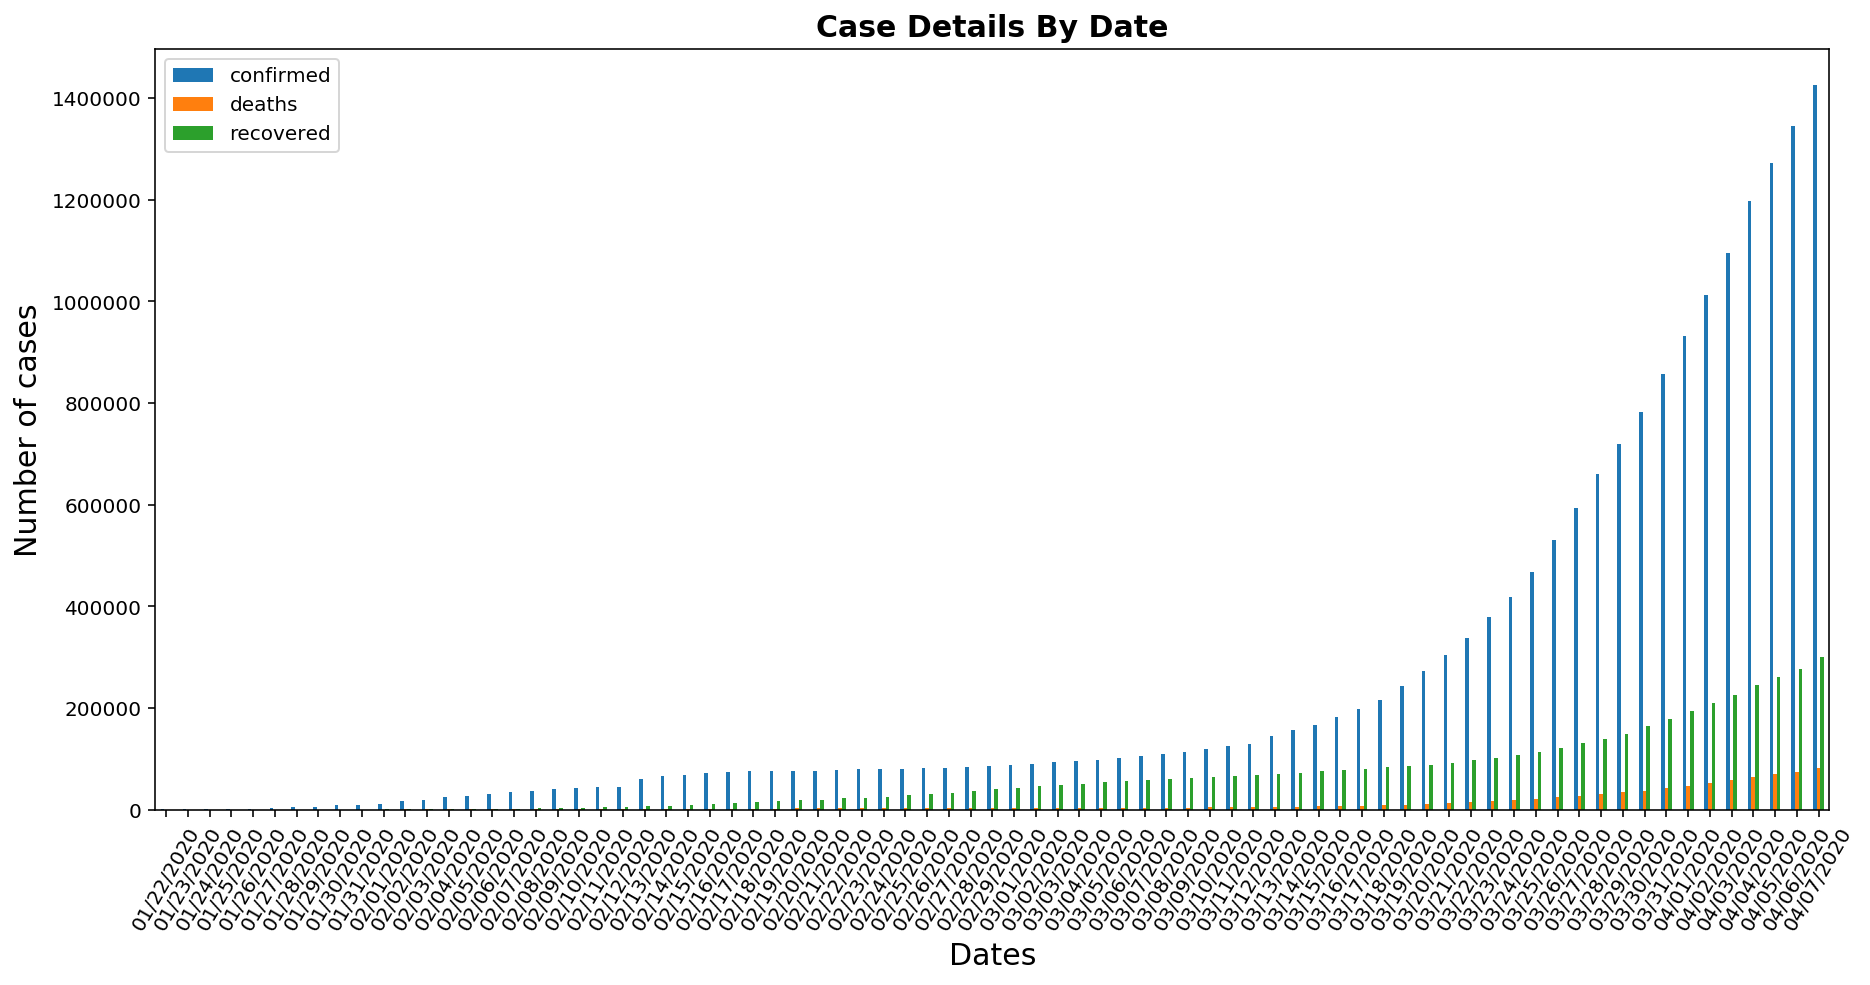

In [15]:
#setting the image size
plt.rcParams['figure.figsize']=(15,7)

#plotting the cases by date
covid19.groupby(['observationdate']).sum().plot(kind='bar');
plt.xticks(rotation=60);
plt.title('Case Details By Date', fontsize = 15 ,weight = 'bold');
plt.ylabel('Number of cases',fontsize=15);
plt.xlabel('Dates',fontsize=15);

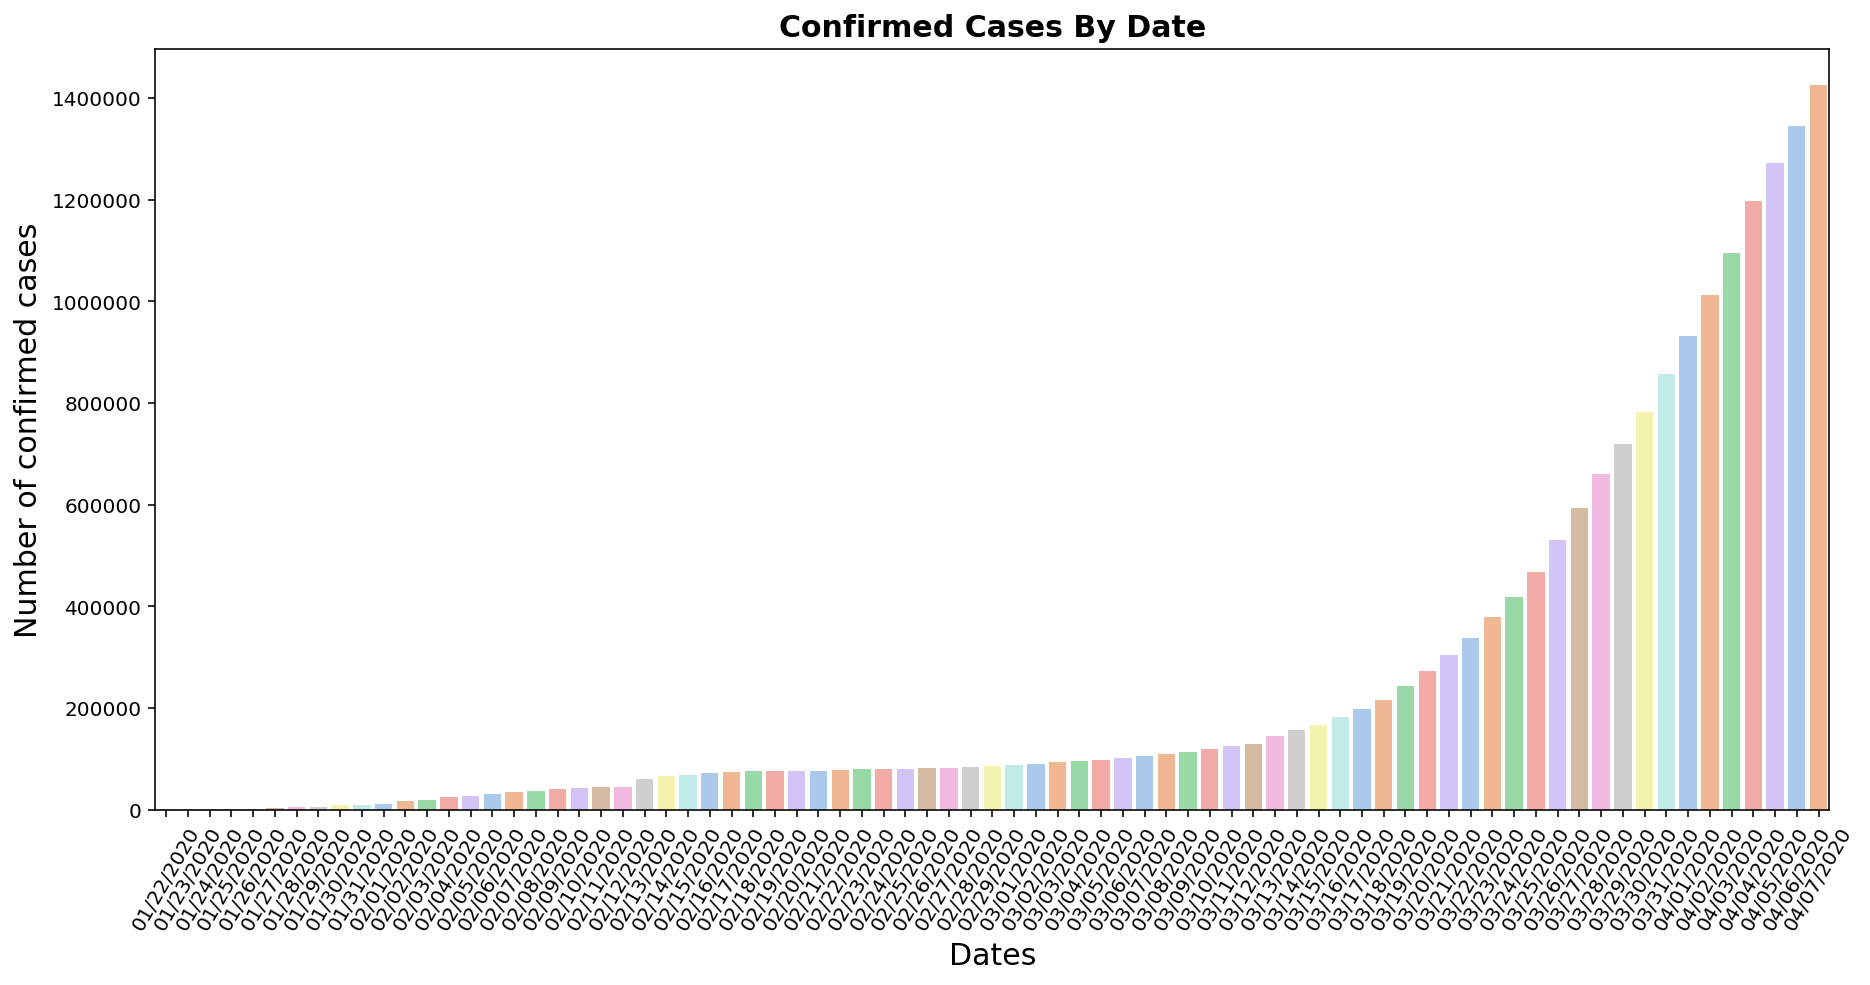

In [16]:
sns.axes_style("whitegrid")
sns.barplot(x="observationdate",
            y="confirmed",
            data=covid19.groupby(['observationdate']).sum().reset_index(drop=None),
            palette=sns.color_palette("pastel", 15));

plt.xticks(rotation=60);
plt.title('Confirmed Cases By Date', fontsize = 15 ,weight = 'bold')
plt.ylabel('Number of confirmed cases',fontsize=15);
plt.xlabel('Dates',fontsize=15);

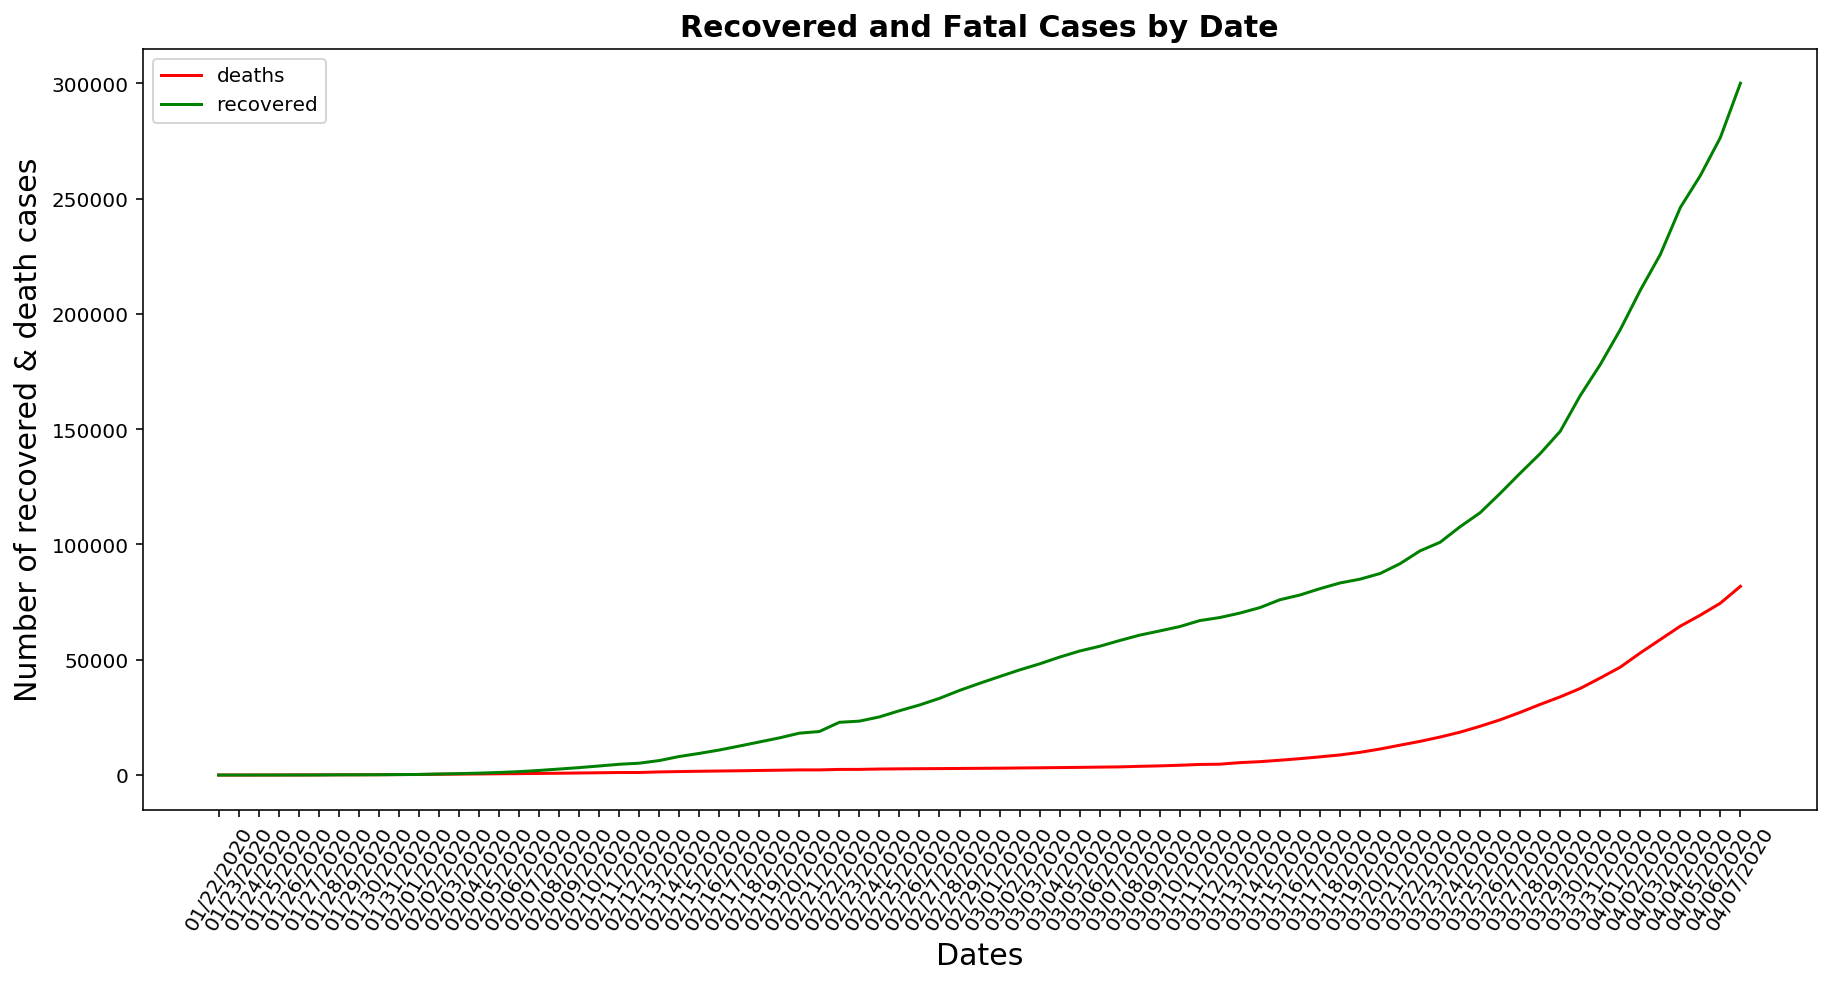

In [17]:
#plotting two line plots for deaths and recoveries respectively
plt.plot('observationdate', 'deaths', data=covid19.groupby(['observationdate']).sum().reset_index(drop=None), color='red')
plt.plot('observationdate', 'recovered', data=covid19.groupby(['observationdate']).sum().reset_index(drop=None), color='green')
plt.title('Recovered and Fatal Cases by Date', fontsize = 15 ,weight = 'bold')
plt.xticks(rotation=60)
plt.ylabel('Number of recovered & death cases',fontsize=15)
plt.xlabel('Dates',fontsize=15)
plt.legend()
plt.show()

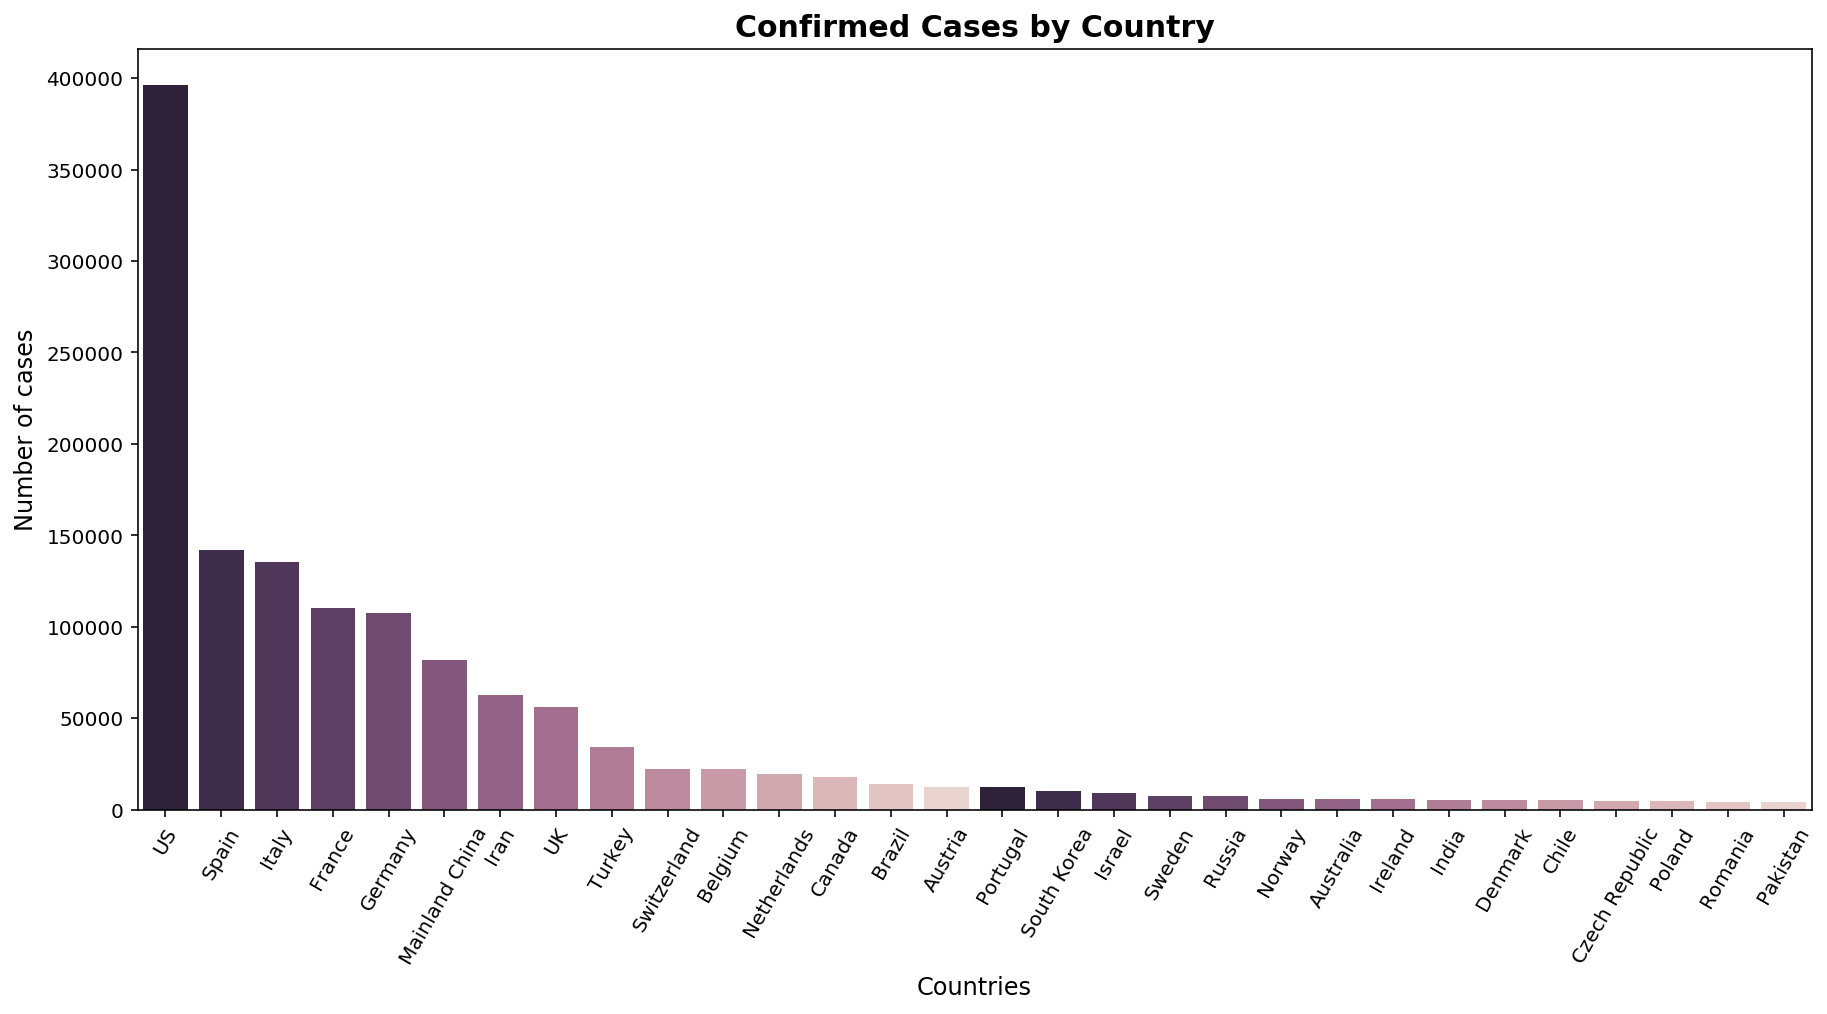

In [18]:
# bar plot to compare countries by confirmed cases
cases_by_country.sort_values(by = 'confirmed', ascending = False, inplace = True) # sorting df by confirmed cases 
sns.barplot(x= 'country_region',
            y="confirmed",
            data=cases_by_country.head(30),
            palette=sns.cubehelix_palette(15, reverse=True)
           )
plt.title('Confirmed Cases by Country', fontsize = 15, weight = 'bold')
plt.xticks(rotation=60)
plt.ylabel('Number of cases',fontsize=12)
plt.xlabel('Countries',fontsize=12);

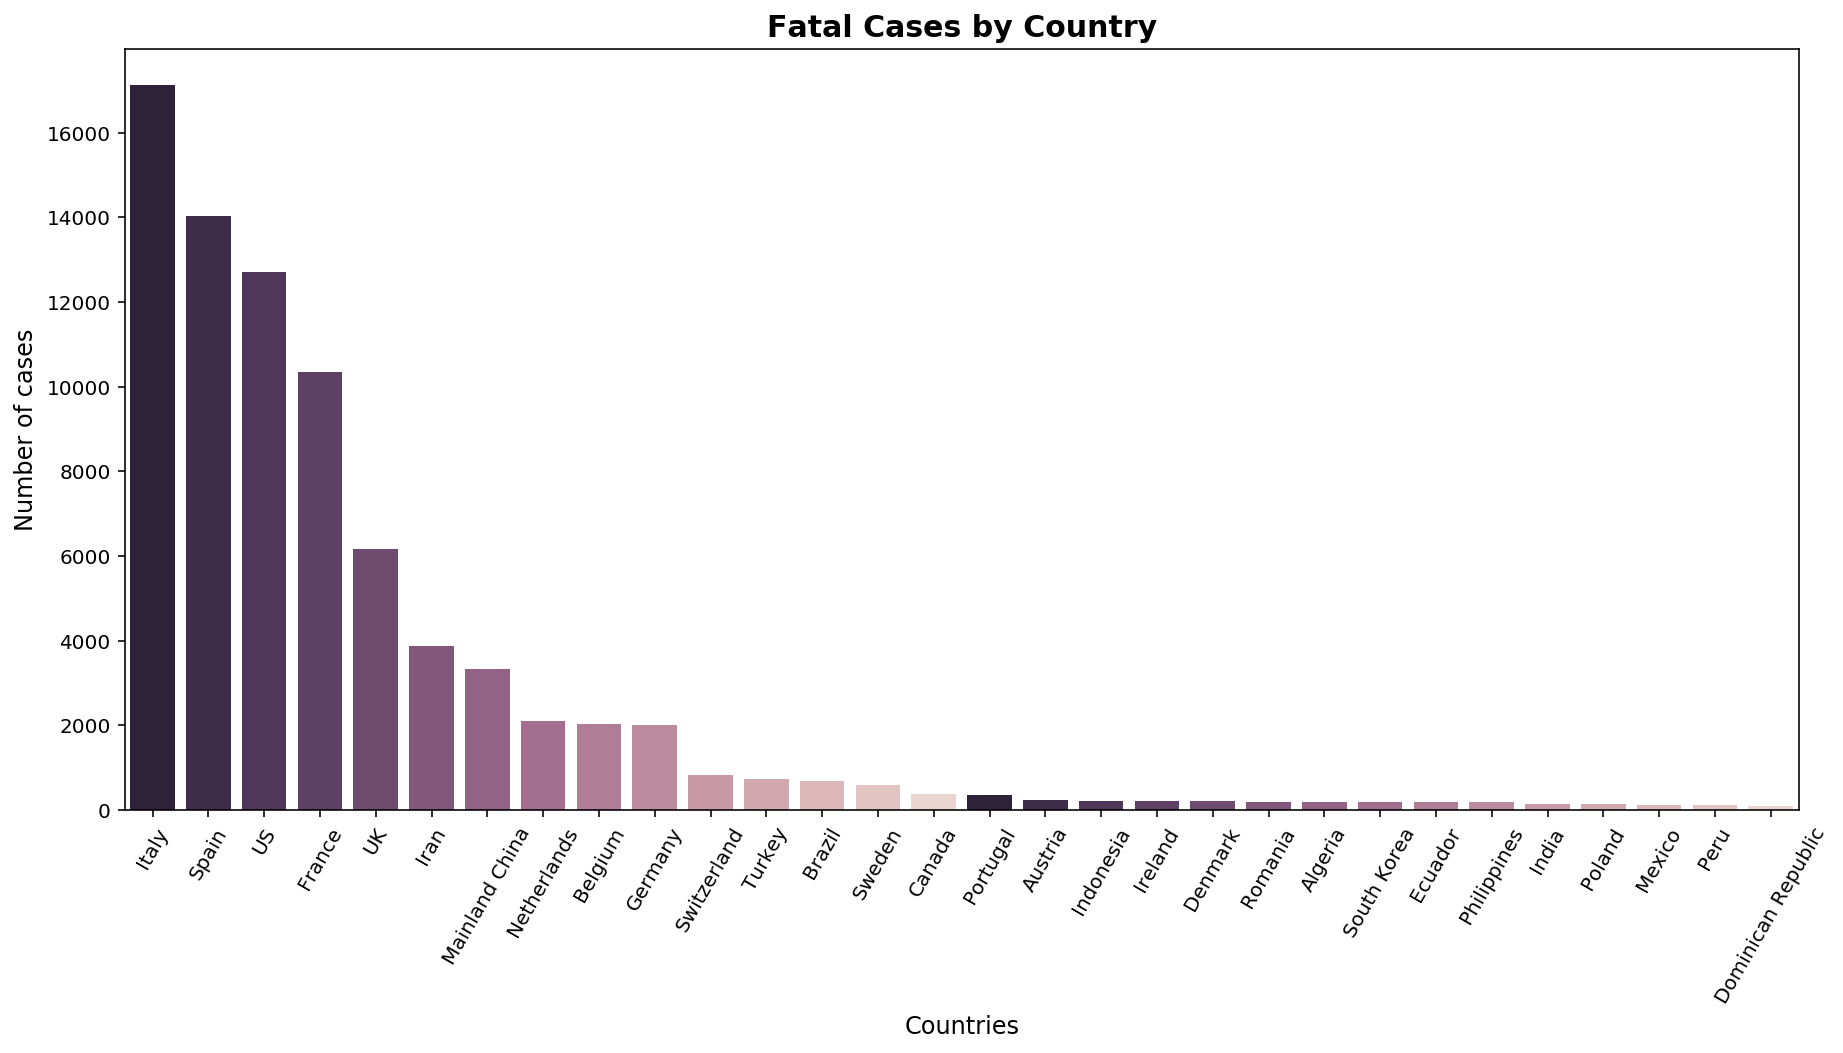

In [19]:
# bar plot to compare countries by fatalities
cases_by_country.sort_values(by = 'deaths', ascending = False, inplace = True) # sorting df by fatal cases 
sns.barplot(x= 'country_region',
            y="deaths",
            data=cases_by_country.head(30),
            palette=sns.cubehelix_palette(15, reverse=True)
           )

plt.title('Fatal Cases by Country', fontsize = 15, weight = 'bold')
plt.xticks(rotation=60)
plt.ylabel('Number of cases',fontsize=12)
plt.xlabel('Countries',fontsize=12);

In [20]:
# total number of confirmed cases by country
cases_by_city = covid19.groupby(['province_state','observationdate'])[['confirmed','deaths','recovered']].sum().reset_index(drop=None)
cases_by_city = cases_by_city[cases_by_city.observationdate == cases_by_city.observationdate.max()]
type(cases_by_city)

pandas.core.frame.DataFrame

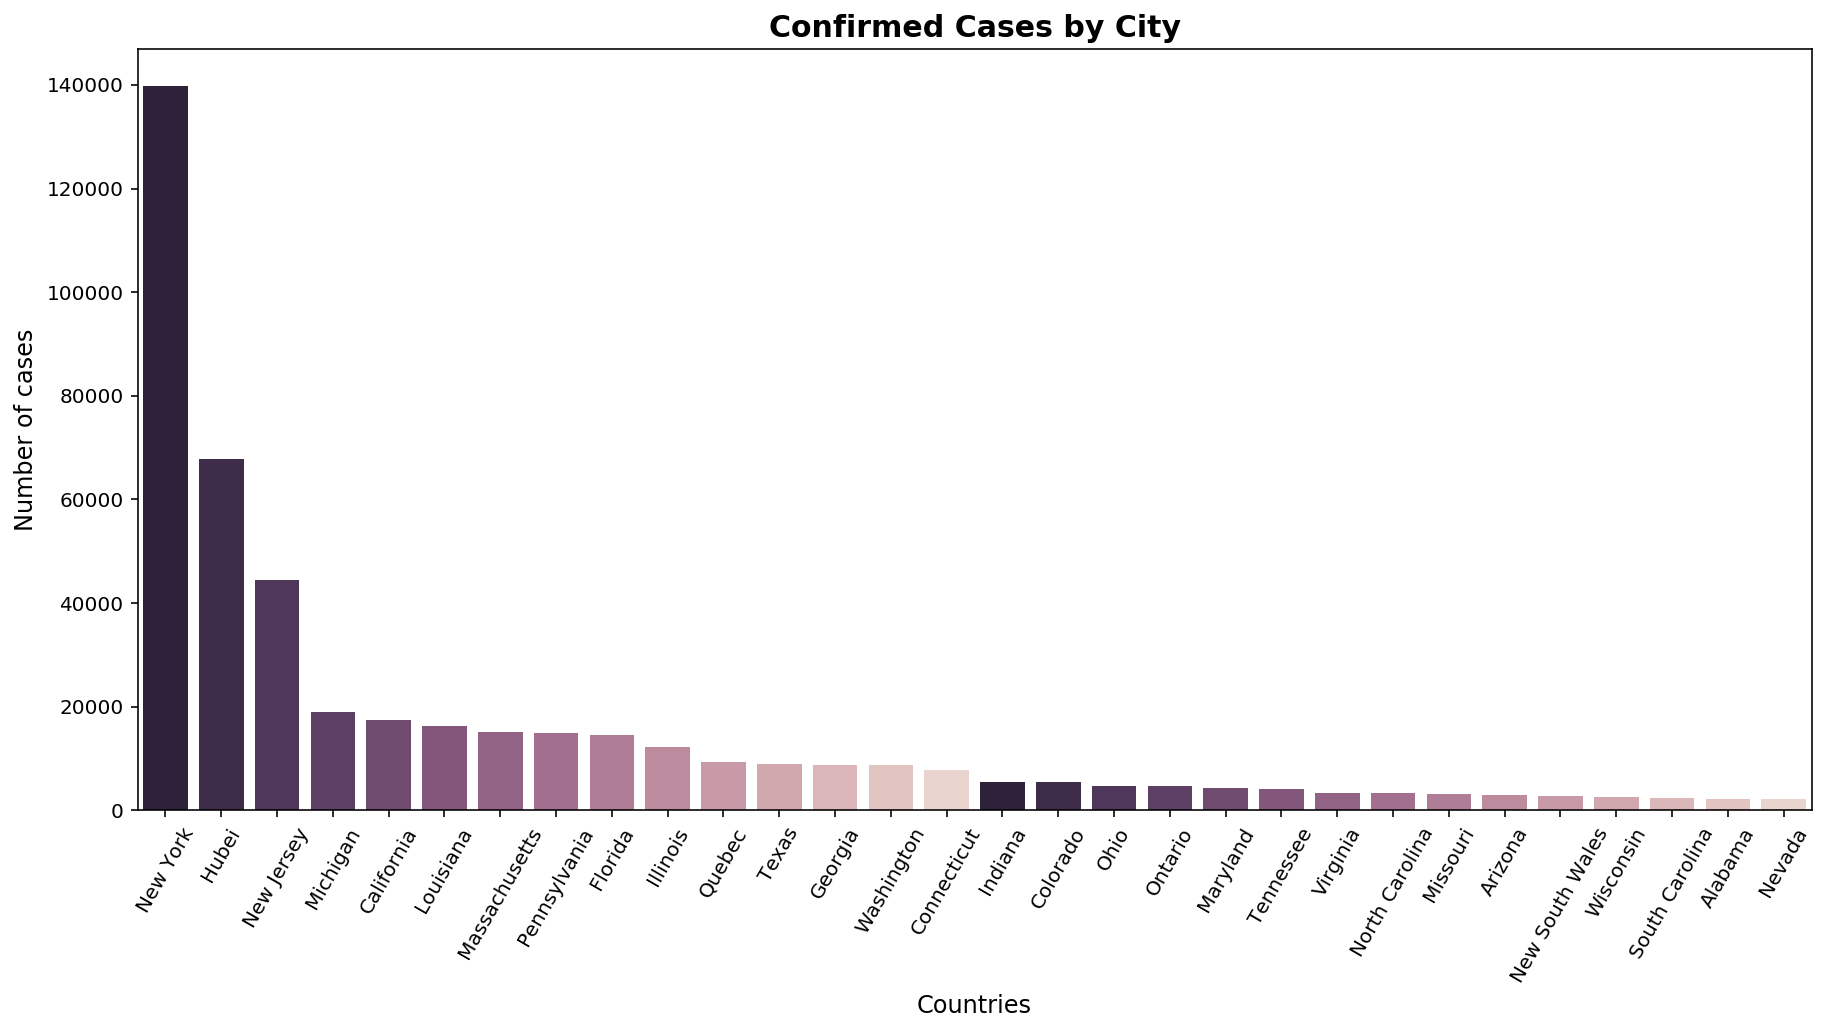

In [21]:
# bar plot to compare citities by confirmed cases
cases_by_city.sort_values(by = 'confirmed', ascending = False, inplace = True) # sorting df by confirmed cases 
sns.barplot(x= 'province_state',
            y="confirmed",
            data=cases_by_city.head(30),
            palette=sns.cubehelix_palette(15, reverse=True)
           )
plt.title('Confirmed Cases by City', fontsize = 15, weight = 'bold')
plt.xticks(rotation=60)
plt.ylabel('Number of cases',fontsize=12)
plt.xlabel('Countries',fontsize=12);

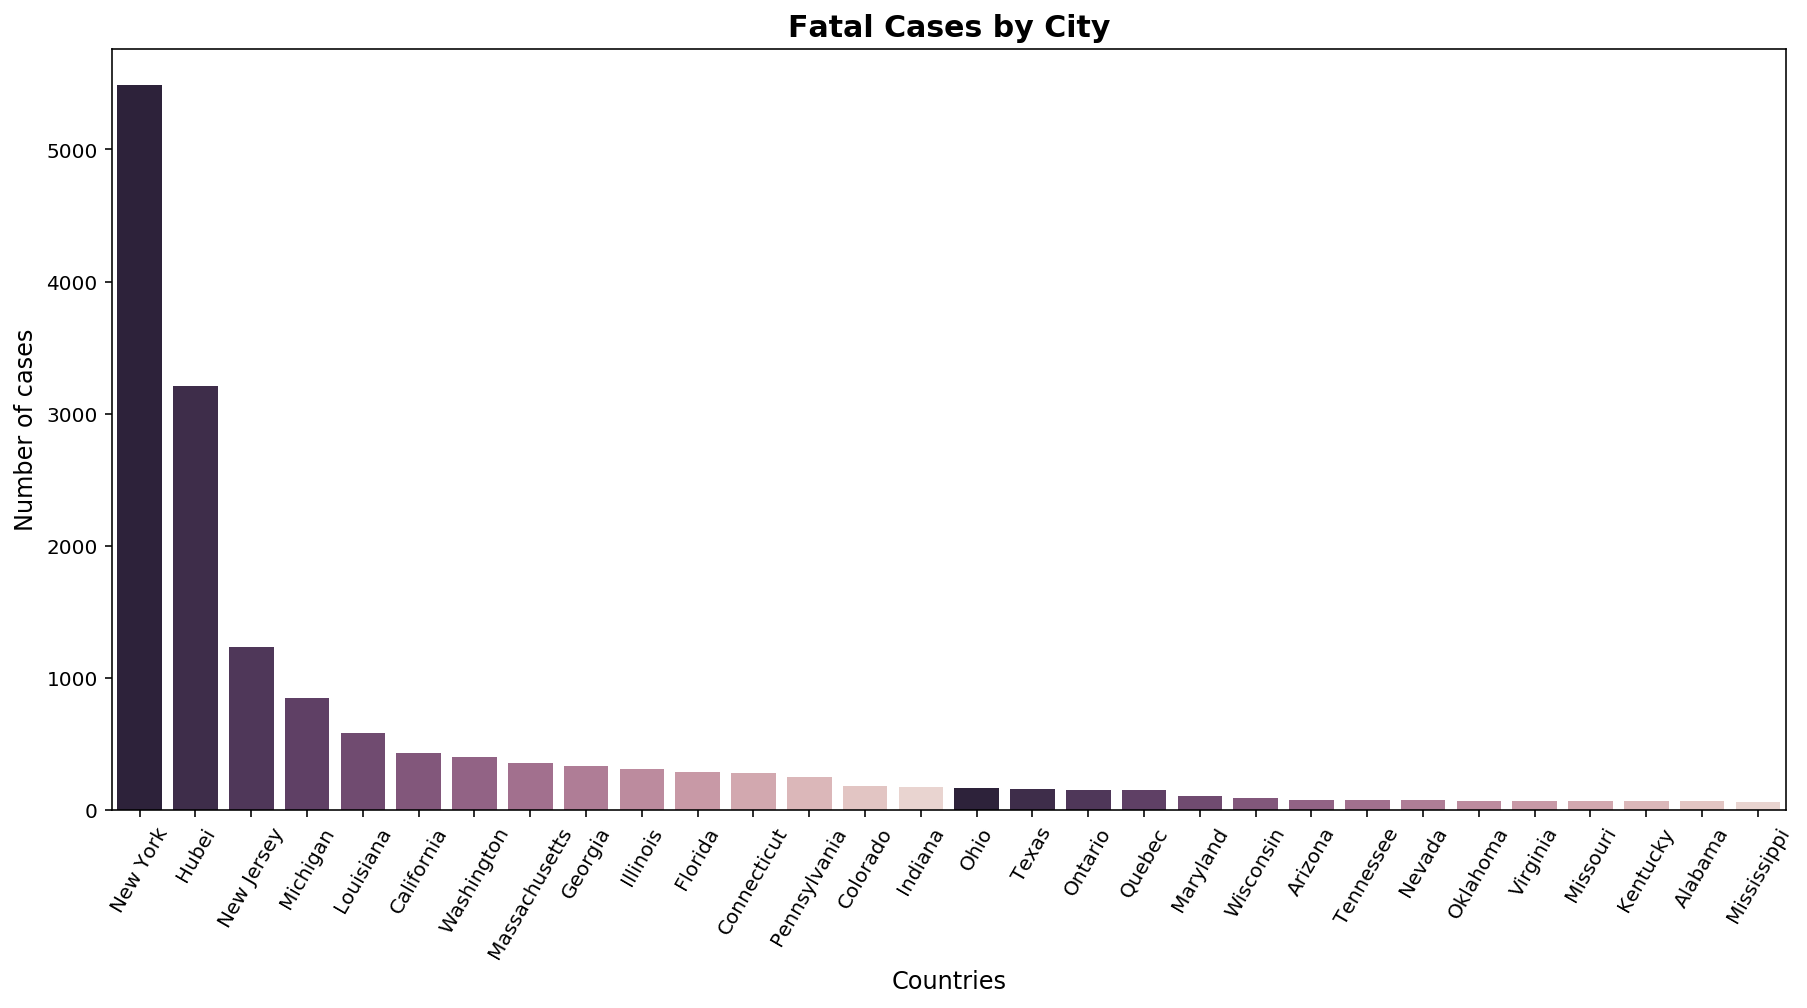

In [22]:
# bar plot to compare cities by fatalities
cases_by_city.sort_values(by = 'deaths', ascending = False, inplace = True) # sorting df by fatal cases 
sns.barplot(x= 'province_state',
            y="deaths",
            data=cases_by_city.head(30),
            palette=sns.cubehelix_palette(15, reverse=True)
           )

plt.title('Fatal Cases by City', fontsize = 15, weight = 'bold')
plt.xticks(rotation=60)
plt.ylabel('Number of cases',fontsize=12)
plt.xlabel('Countries',fontsize=12);

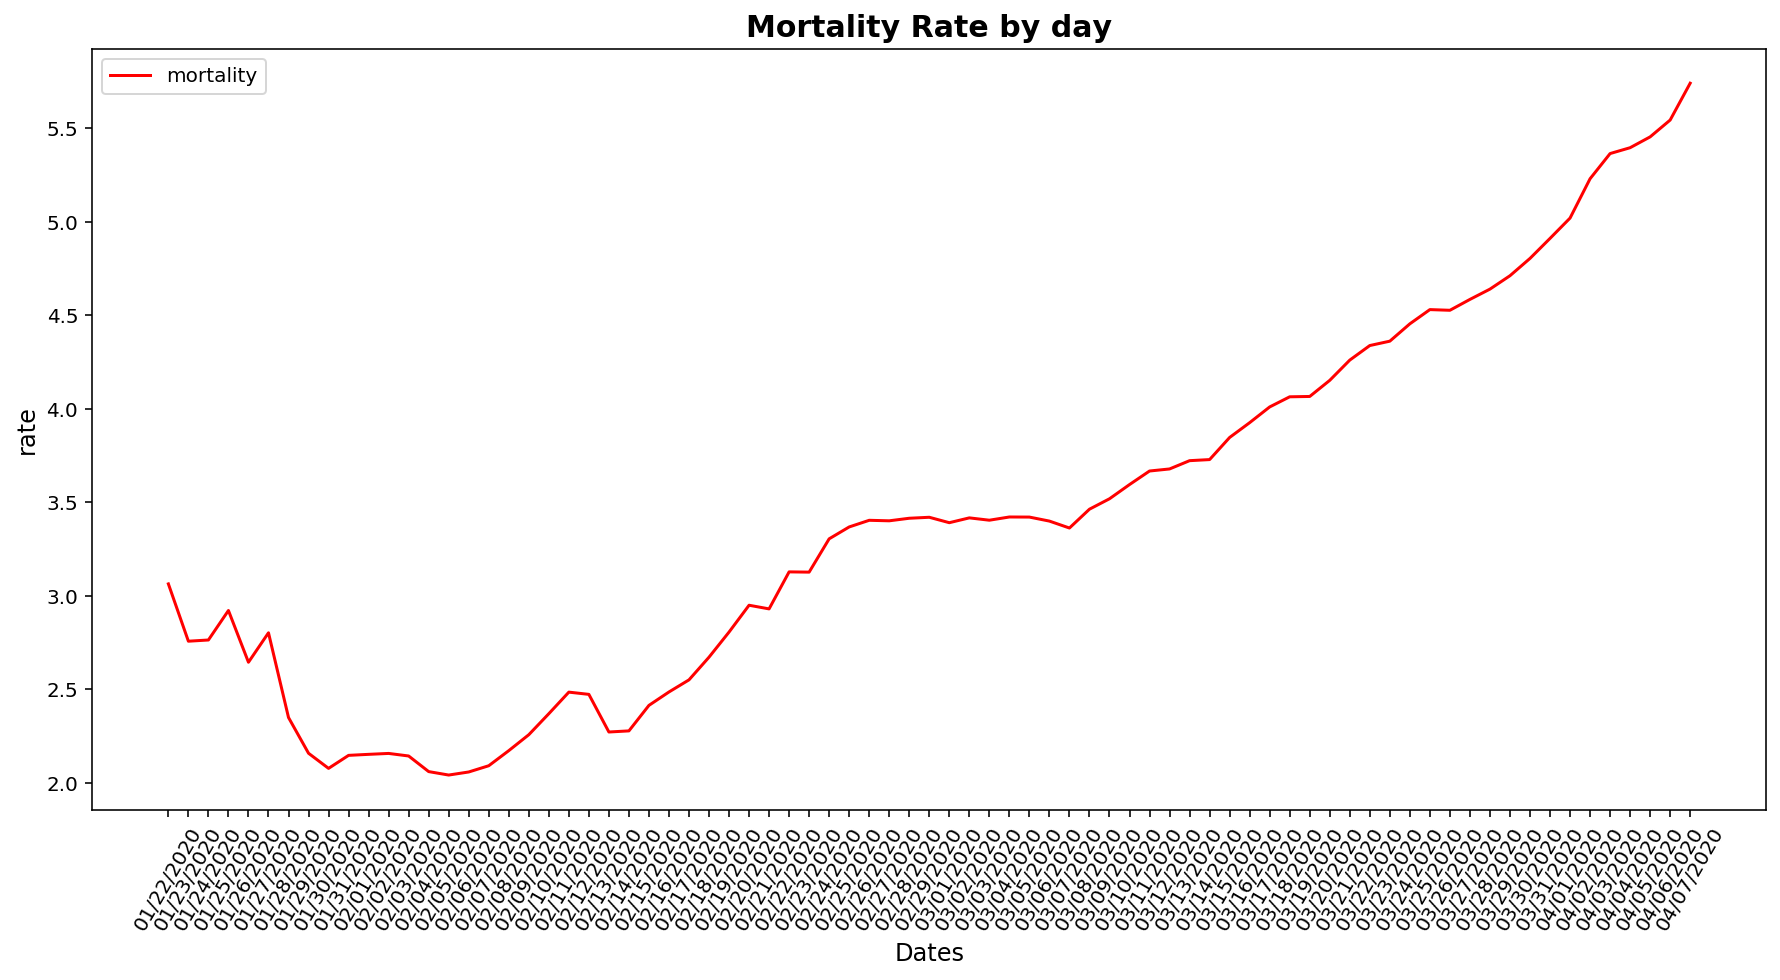

In [23]:
#plotting mortality rates
plt.plot('observationdate', 'mortality', data=cases_by_date.groupby(['observationdate']).sum().reset_index(drop=None), color='red')
# plt.plot('observationdate', 'recovered', data=covid19.groupby(['observationdate']).sum().reset_index(drop=None), color='green')
plt.title('Mortality Rate by day', fontsize = 15 ,weight = 'bold')
plt.xticks(rotation=60)
plt.ylabel('rate',fontsize=12)
plt.xlabel('Dates',fontsize=12)
plt.legend()
plt.show()

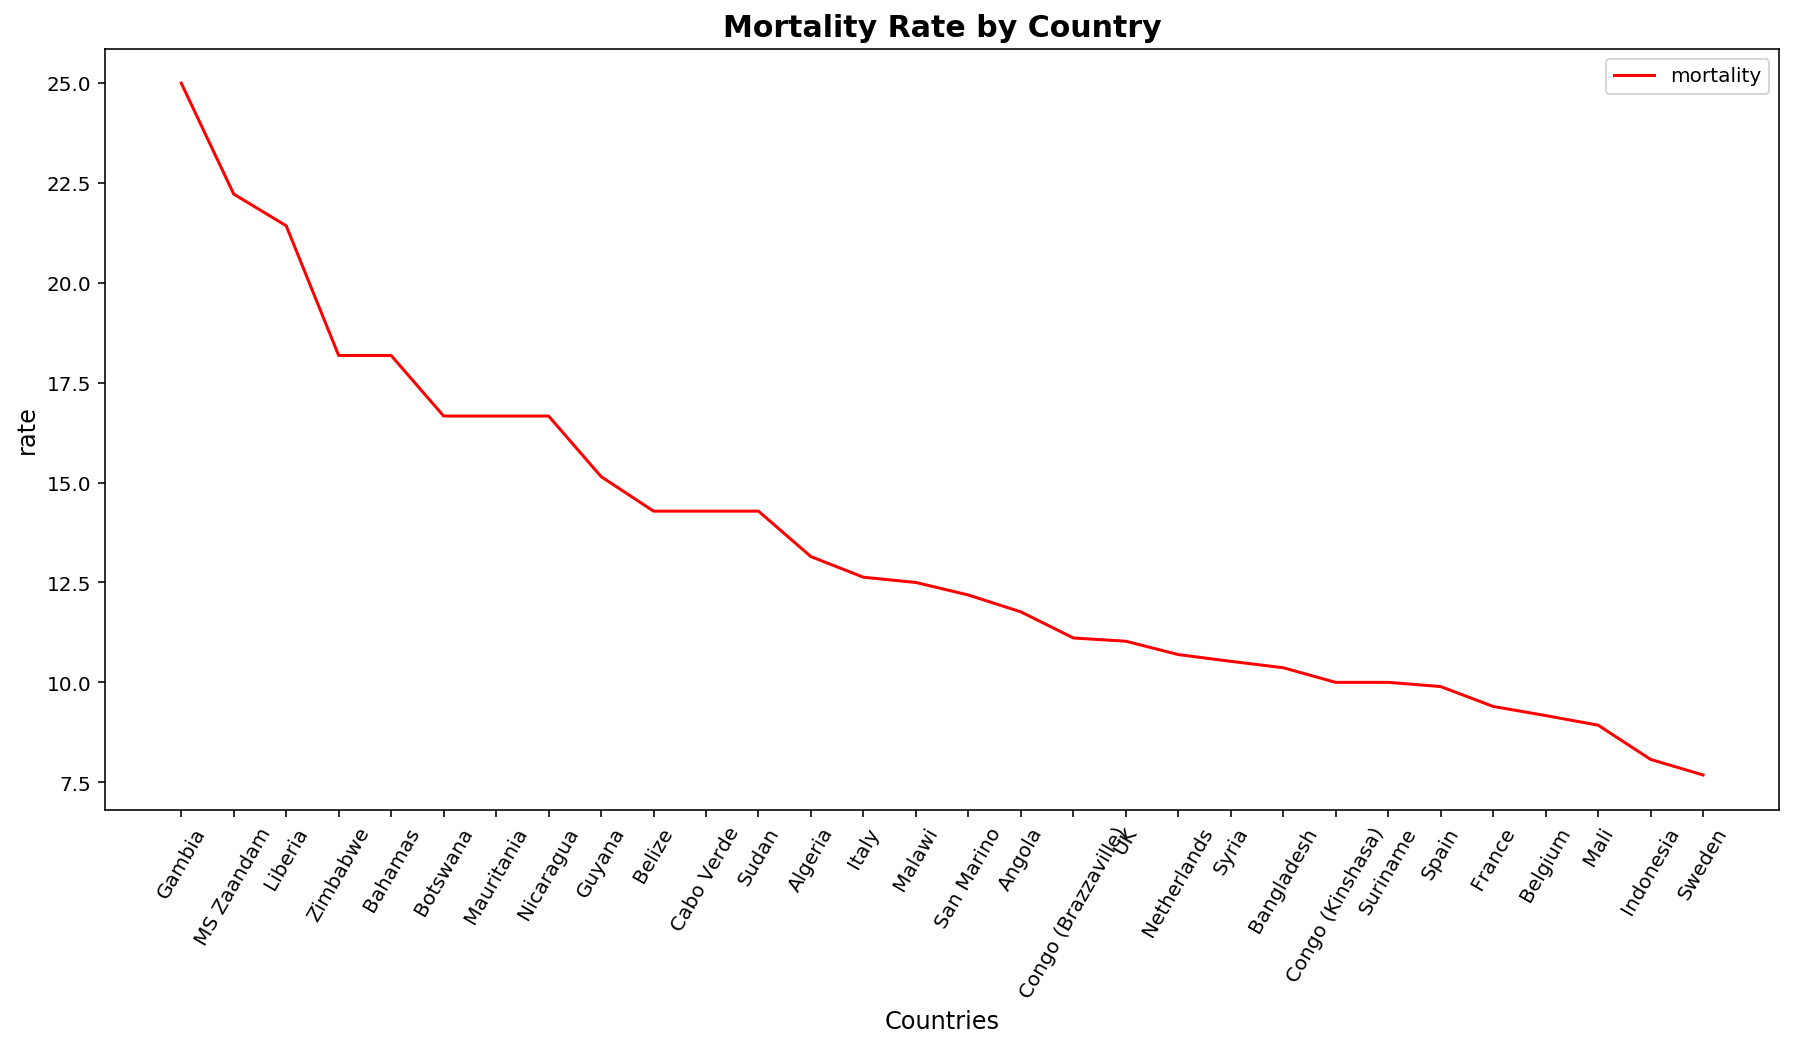

In [24]:
#plotting mortality rates
plt.plot('country_region', 'mortality', data=cases_by_country.sort_values(by = 'mortality', ascending = False).head(30).reset_index(drop=None), color='red')
# plt.plot('observationdate', 'recovered', data=covid19.groupby(['observationdate']).sum().reset_index(drop=None), color='green')
plt.title('Mortality Rate by Country', fontsize = 15 ,weight = 'bold')
plt.xticks(rotation=60)
plt.ylabel('rate',fontsize=12)
plt.xlabel('Countries',fontsize=12)
plt.legend()
plt.show()

### Pre-processing

    1. Reading time-series data from JHU CSSE github - 2 different files for confirmed & fatal cases by day (files are updated on a daily basis)
    2. Structure the read files with index as date
    3. Combine both dataframes into 1 
    4. Split into training and validation sets
    5. Scale confirmed and fatal case data with MinMax Scaler
    6. Generate batches of temporal data using TimeseriesGenerator  

#### Reading files and saving to a structured dataframe

In [125]:
file = "../datasets/covid/time_series_covid19_confirmed_global.csv"
confirmed_cases = pd.read_csv(file)
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,484,521,555,607,665,714,784,840,906,933
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,409,416,433,446,467,475,494,518,539,548
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,583,601,601,638,646,659,673,673,696,704
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,19,24


In [126]:
## building time series data - structuring df
confirmed_cases_str = pd.DataFrame(confirmed_cases[confirmed_cases.columns[4:]].sum(),columns=["confirmed"])
confirmed_cases_str.index = pd.to_datetime(confirmed_cases_str.index,format='%m/%d/%y')
confirmed_cases_str.tail()

,confirmed
2020-04-14,1976191
2020-04-15,2056054
2020-04-16,2152437
2020-04-17,2240190
2020-04-18,2317758


In [127]:
## total fatal cases
fatalities = pd.read_csv("../datasets/covid/time_series_covid19_deaths_global.csv")
fatalities.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15,15,18,18,21,23,25,30,30,30
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,23,23,23,23,23,24,25,26,26,26
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,235,256,275,293,313,326,336,348,364,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,25,26,26,29,29,31,33,33,35,35
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [128]:
# structuring df
fatalities_str = pd.DataFrame(fatalities[fatalities.columns[4:]].sum(),columns=["fatalities"])
fatalities_str.index = pd.to_datetime(fatalities_str.index,format='%m/%d/%y')
fatalities_str.tail()

,fatalities
2020-04-14,125983
2020-04-15,134176
2020-04-16,143800
2020-04-17,153821
2020-04-18,159509


#### Combining confirmed & fatal cases dataframes to a single one

In [129]:
# combine dataframes
combined_df = confirmed_cases_str.join(fatalities_str,how = "inner")
combined_df

,confirmed,fatalities
2020-01-22,555,17
2020-01-23,654,18
2020-01-24,941,26
2020-01-25,1434,42
2020-01-26,2118,56
...,...,...
2020-04-14,1976191,125983
2020-04-15,2056054,134176
2020-04-16,2152437,143800
2020-04-17,2240190,153821


#### Generating training and validation sets

In [130]:
training_percentage = 0.9

training = int(len(combined_df)*training_percentage)
validation = len(combined_df)-int(len(combined_df)*training_percentage)
training_df = combined_df[:training]
validation_df = combined_df[training:]

In [131]:
training_df.shape, validation_df.shape

((79, 2), (9, 2))

#### Scaling using MinMax Scaler

Since our case related data is is heavily skewed (starts from zero and goes up explonentially), we will normalize the data(divide every value by max value of data set) based on training set.

In [132]:
##scale or normalize data as the data is too skewed
scaler = MinMaxScaler()

In [133]:
scaler.fit(training_df) #find max value
scaled_train = scaler.transform(training_df)#and divide every point by max value
scaled_test = scaler.transform(validation_df)
print(scaled_train[-5:])

[[0.79835153 0.72622089]
 [0.84419159 0.78057464]
 [0.8921202  0.85776512]
 [0.94562872 0.92478849]
 [1.         1.        ]]


In [134]:
scaled_train.shape

(79, 2)

#### Generating batches of temporal data using Keras's TimeseriesGenerator

Produce batches for training/validation from a regular time series data to train the model. 
Due to the huge variations of data over time, the # of steps takes is as small as 5 steps - which will be most latest 5 data points to predict 6th data point.

In [135]:
n_input = 6  # number of steps
n_features = 2 # number of features to predict (confirmed & fatal cases) - multivariate time series model
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size=1)

In [136]:
scaled_train.shape, len(generator)

((79, 2), 73)

### Modeling

#### Baseline score

In [ ]:
combined_df.confirmed

In [137]:
model = Sequential()
model.add(LSTM(150,activation="relu",input_shape=(n_input,n_features)))
model.add(Dense(75, activation='relu'))
model.add(Dense(units=2))
model.compile(optimizer="adam",loss="mse")

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 150)               91800     
_________________________________________________________________
dense_7 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 152       
Total params: 103,277
Trainable params: 103,277
Non-trainable params: 0
_________________________________________________________________


In [138]:
val_generator = TimeseriesGenerator(scaled_test,scaled_test,length = n_input,batch_size=1)

#### Model training

1. Used early stopping mechanism of keras which stops training when val_loss has stopped improving
2. Patience of 20 iterations is given so as to continue the training for 20 iterations even if there is n improvement in val_loss
3. Used the flag “restore_best_weights” which takes the best weights from all epochs where val loss in the least

In [139]:
early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

In [140]:
model.fit_generator(generator,validation_data=val_generator,epochs=100,callbacks=[early_stop],steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 1s 124ms/step - loss: 0.0037 - val_loss: 2.1319
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0367 - val_loss: 1.6375
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1027 - val_loss: 0.8691
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0230 - val_loss: 0.4353
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.2592
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0182 - val_loss: 0.1963
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.5681
Epoch 8/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0051 - val_loss: 0.0516
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0139 - val_loss: 0.2112
Epoch 10/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 1.305

### Model Performance

**Model performance looks fairly good as the training and validation loss overlaps at the minimum value.** 

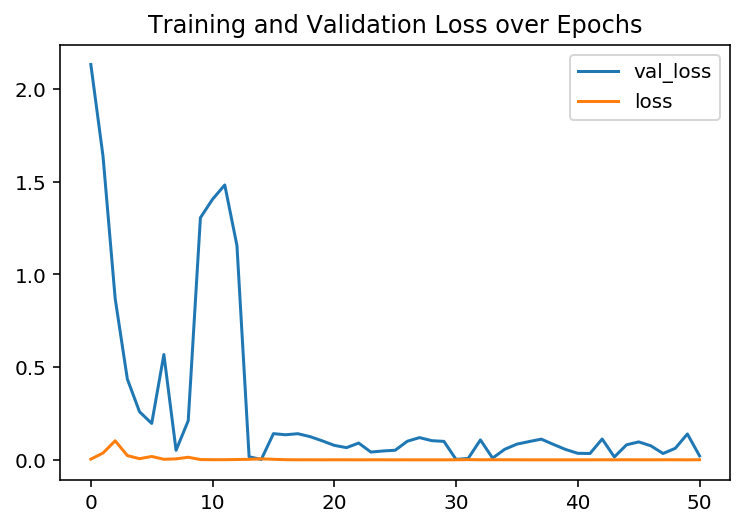

In [141]:
#setting the image size
plt.rcParams['figure.figsize']=(6,4)
pd.DataFrame(model.history.history).plot(title="Training and Validation Loss over Epochs")

### Forecast

In [142]:
##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)
current_batch.shape

(1, 6, 2)

In [143]:
## list to store predictions
test_prediction = []
## forecasting for the next 7 days
for i in range(len(validation_df)+7):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    # current batch is updated with the new predictions replacing the first record used to predict
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 

In [144]:
validation_df

,confirmed,fatalities
2020-04-10,1657526,102525
2020-04-11,1735650,108502
2020-04-12,1834721,114090
2020-04-13,1904838,119481
2020-04-14,1976191,125983
2020-04-15,2056054,134176
2020-04-16,2152437,143800
2020-04-17,2240190,153821
2020-04-18,2317758,159509


In [145]:
### inverse transform predicted values
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction.shape

(16, 2)

In [146]:
true_prediction

array([[1493533.89792752,   97466.05278778],
       [1566785.71808732,  103264.69957161],
       [1642292.86663926,  109319.08680153],
       [1720558.7867502 ,  115546.20670509],
       [1798732.56127965,  121723.97278976],
       [1877889.53289413,  127953.07367706],
       [1957370.31975043,  134185.99991226],
       [2058265.44129634,  142319.42957115],
       [2167245.68476415,  151133.47514725],
       [2285892.82045949,  160778.47509003],
       [2416510.11486042,  171465.75710106],
       [2562960.59426761,  183540.01235008],
       [2729950.02534032,  197443.1595993 ],
       [2923985.86334419,  213788.34746933],
       [3148326.03282618,  232853.85863495],
       [3412646.56596017,  255514.10387039]])

In [147]:
time_series_array = validation_df.index
for k in range(0,7):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25'],
              dtype='datetime64[ns]', freq=None)

In [148]:
forecast_df = pd.DataFrame(columns=["confirmed","confirmed_predicted", "fatalities", "fatalities_predicted"],index=time_series_array)
forecast_df

,confirmed,confirmed_predicted,fatalities,fatalities_predicted
2020-04-10,NaN,NaN,NaN,NaN
2020-04-11,NaN,NaN,NaN,NaN
2020-04-12,NaN,NaN,NaN,NaN
2020-04-13,NaN,NaN,NaN,NaN
2020-04-14,NaN,NaN,NaN,NaN
2020-04-15,NaN,NaN,NaN,NaN
2020-04-16,NaN,NaN,NaN,NaN
2020-04-17,NaN,NaN,NaN,NaN
2020-04-18,NaN,NaN,NaN,NaN
2020-04-19,NaN,NaN,NaN,NaN


In [149]:
forecast_df.loc[:,"confirmed"] = validation_df["confirmed"]
forecast_df.loc[:,"confirmed_predicted"] = true_prediction[:,0].round(0)

forecast_df.loc[:,"fatalities"] = validation_df["fatalities"]
forecast_df.loc[:,"fatalities_predicted"] = true_prediction[:,1].round(0)

In [151]:
forecast_df

,confirmed,confirmed_predicted,fatalities,fatalities_predicted
2020-04-10,1657526.0,1493534.0,102525.0,97466.0
2020-04-11,1735650.0,1566786.0,108502.0,103265.0
2020-04-12,1834721.0,1642293.0,114090.0,109319.0
2020-04-13,1904838.0,1720559.0,119481.0,115546.0
2020-04-14,1976191.0,1798733.0,125983.0,121724.0
2020-04-15,2056054.0,1877890.0,134176.0,127953.0
2020-04-16,2152437.0,1957370.0,143800.0,134186.0
2020-04-17,2240190.0,2058265.0,153821.0,142319.0
2020-04-18,2317758.0,2167246.0,159509.0,151133.0
2020-04-19,NaN,2285893.0,NaN,160778.0


In [152]:
forecast_confirmedcases = forecast_df[['confirmed','confirmed_predicted']]
forecast_confirmedcases

,confirmed,confirmed_predicted
2020-04-10,1657526.0,1493534.0
2020-04-11,1735650.0,1566786.0
2020-04-12,1834721.0,1642293.0
2020-04-13,1904838.0,1720559.0
2020-04-14,1976191.0,1798733.0
2020-04-15,2056054.0,1877890.0
2020-04-16,2152437.0,1957370.0
2020-04-17,2240190.0,2058265.0
2020-04-18,2317758.0,2167246.0
2020-04-19,NaN,2285893.0


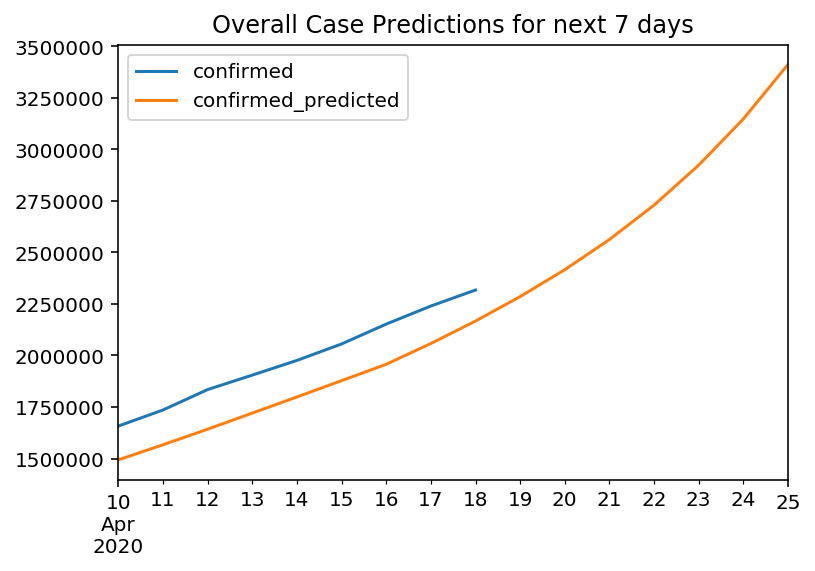

In [153]:
forecast_confirmedcases.plot(title="Overall Case Predictions for next 7 days")

In [154]:
forecast_fatalities = forecast_df[['fatalities','fatalities_predicted']]
forecast_fatalities

,fatalities,fatalities_predicted
2020-04-10,102525.0,97466.0
2020-04-11,108502.0,103265.0
2020-04-12,114090.0,109319.0
2020-04-13,119481.0,115546.0
2020-04-14,125983.0,121724.0
2020-04-15,134176.0,127953.0
2020-04-16,143800.0,134186.0
2020-04-17,153821.0,142319.0
2020-04-18,159509.0,151133.0
2020-04-19,NaN,160778.0


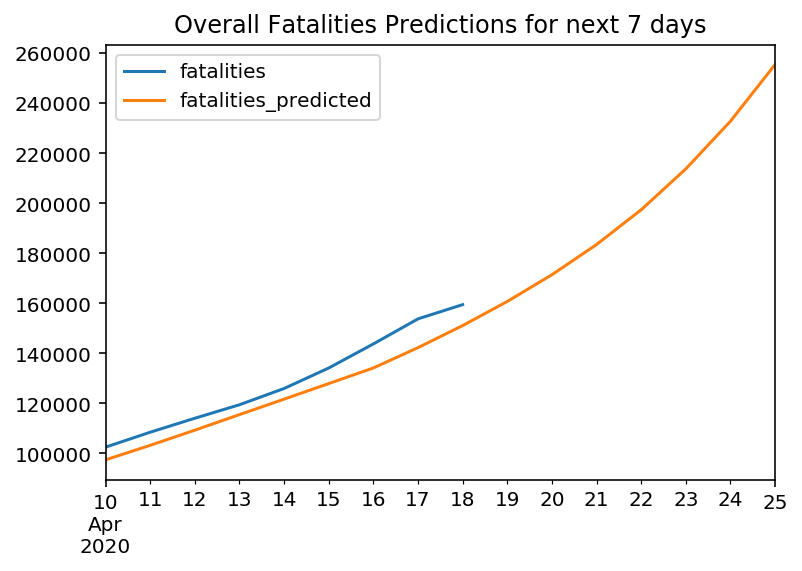

In [155]:
forecast_fatalities.plot(title="Overall Fatalities Predictions for next 7 days")

In [156]:
forecast_confirmedcases["confirmed"][:9]

2020-04-10    1657526.0
2020-04-11    1735650.0
2020-04-12    1834721.0
2020-04-13    1904838.0
2020-04-14    1976191.0
2020-04-15    2056054.0
2020-04-16    2152437.0
2020-04-17    2240190.0
2020-04-18    2317758.0
Name: confirmed, dtype: float64

In [157]:
MAPE = round(np.mean(np.abs(np.array(forecast_confirmedcases["confirmed"][:9]) - np.array(forecast_confirmedcases["confirmed_predicted"][:9]))/np.array(forecast_confirmedcases["confirmed"][:9])),2)
print("MAPE is " + str(MAPE*100) + "%")
RMSLE = round(np.sqrt(mean_squared_log_error(np.array(forecast_confirmedcases["confirmed"][:9]), 
                                             np.array(forecast_confirmedcases["confirmed_predicted"][:9]))),2)
print("RMS Log Error " + str(RMSLE))
sum_errs = round(np.sum((np.array(forecast_confirmedcases["confirmed"][:9]) - np.array(forecast_confirmedcases["confirmed_predicted"][:9]))**2),2)
print("Sum of errors is " + str(sum_errs))
stdev = round(np.sqrt(1/(5-2) * sum_errs),2)
print("Standard deviation is " + str(stdev))
interval = round((1.96 * stdev),2)
print("Prediction interval is " + str(interval))

MAPE is 9.0%
RMS Log Error 0.1
Sum of errors is 283431166503.0
Standard deviation is 307371.2
Prediction interval is 602447.55


In [158]:
forecast_confirmedcases["confirm_min"] = forecast_confirmedcases["confirmed_predicted"] - interval
forecast_confirmedcases["confirm_max"] = forecast_confirmedcases["confirmed_predicted"] + interval
forecast_confirmedcases

/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,confirmed,confirmed_predicted,confirm_min,confirm_max
2020-04-10,1657526.0,1493534.0,891086.45,2095981.55
2020-04-11,1735650.0,1566786.0,964338.45,2169233.55
2020-04-12,1834721.0,1642293.0,1039845.45,2244740.55
2020-04-13,1904838.0,1720559.0,1118111.45,2323006.55
2020-04-14,1976191.0,1798733.0,1196285.45,2401180.55
2020-04-15,2056054.0,1877890.0,1275442.45,2480337.55
2020-04-16,2152437.0,1957370.0,1354922.45,2559817.55
2020-04-17,2240190.0,2058265.0,1455817.45,2660712.55
2020-04-18,2317758.0,2167246.0,1564798.45,2769693.55
2020-04-19,NaN,2285893.0,1683445.45,2888340.55


In [159]:
forecast_confirmedcases["Model Accuracy"] = round(((1-MAPE)*100),2)
forecast_confirmedcases

,confirmed,confirmed_predicted,confirm_min,confirm_max,Model Accuracy
2020-04-10,1657526.0,1493534.0,891086.45,2095981.55,91.0
2020-04-11,1735650.0,1566786.0,964338.45,2169233.55,91.0
2020-04-12,1834721.0,1642293.0,1039845.45,2244740.55,91.0
2020-04-13,1904838.0,1720559.0,1118111.45,2323006.55,91.0
2020-04-14,1976191.0,1798733.0,1196285.45,2401180.55,91.0
2020-04-15,2056054.0,1877890.0,1275442.45,2480337.55,91.0
2020-04-16,2152437.0,1957370.0,1354922.45,2559817.55,91.0
2020-04-17,2240190.0,2058265.0,1455817.45,2660712.55,91.0
2020-04-18,2317758.0,2167246.0,1564798.45,2769693.55,91.0
2020-04-19,NaN,2285893.0,1683445.45,2888340.55,91.0


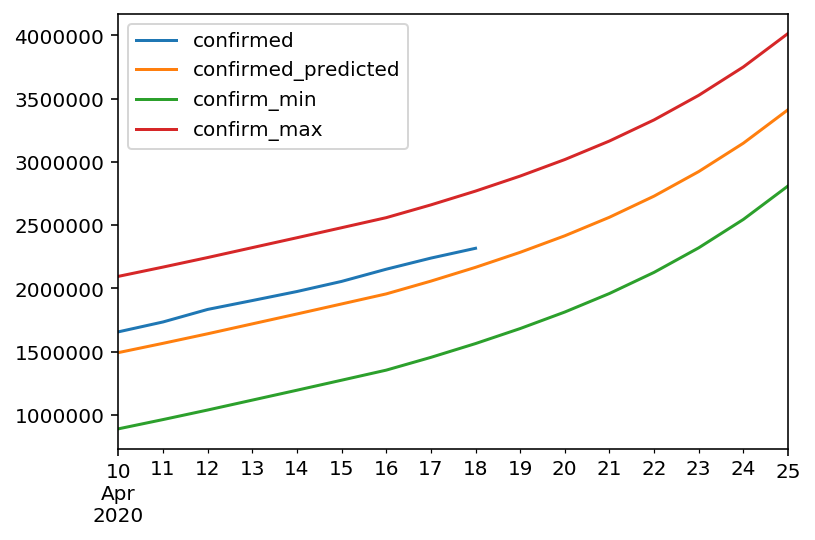

In [160]:
forecast_confirmedcases.iloc[:,:4].plot()

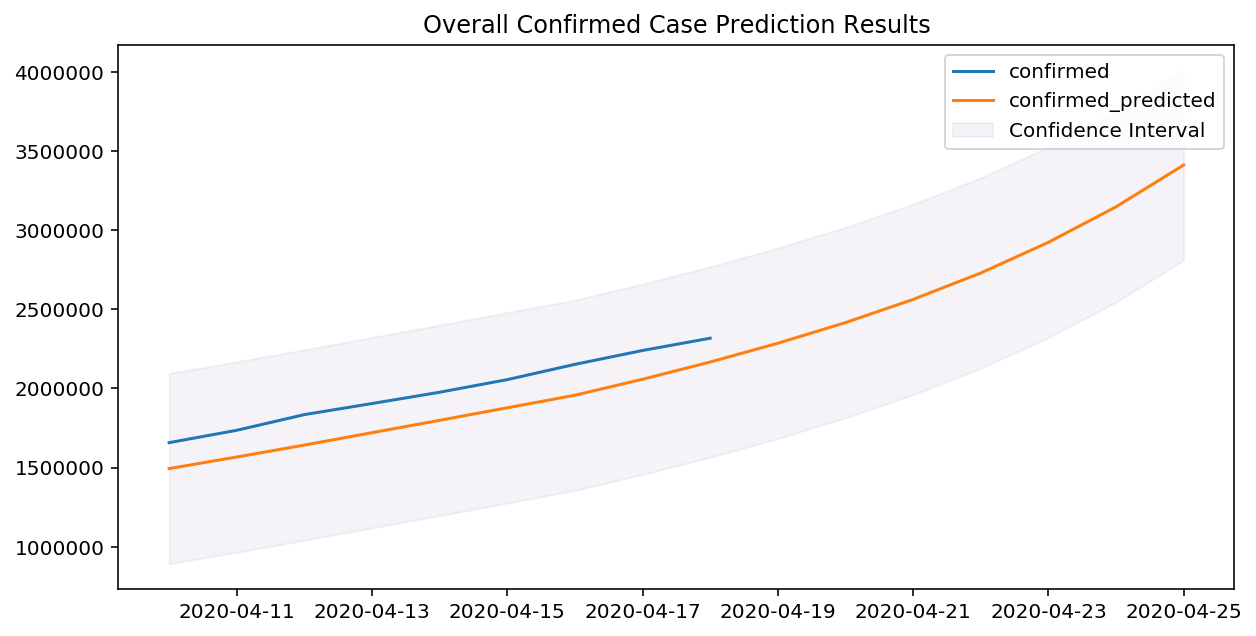

In [161]:
fig= plt.figure(figsize=(10,5))
plt.title("Overall Confirmed Case Prediction Results")
plt.plot(forecast_confirmedcases.index,forecast_confirmedcases["confirmed"],label="confirmed")
plt.plot(forecast_confirmedcases.index,forecast_confirmedcases["confirmed_predicted"],label="confirmed_predicted")
#ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.fill_between(forecast_confirmedcases.index,forecast_confirmedcases["confirm_min"],forecast_confirmedcases["confirm_max"],color="indigo",alpha=0.05,label="Confidence Interval")
plt.legend()
plt.show()

In [162]:
forecast_fatalities["fatalities"][:9]

2020-04-10    102525.0
2020-04-11    108502.0
2020-04-12    114090.0
2020-04-13    119481.0
2020-04-14    125983.0
2020-04-15    134176.0
2020-04-16    143800.0
2020-04-17    153821.0
2020-04-18    159509.0
Name: fatalities, dtype: float64

In [163]:
MAPE_fat = round(np.mean(np.abs(np.array(forecast_fatalities["fatalities"][:9]) - np.array(forecast_fatalities["fatalities_predicted"][:9]))/np.array(forecast_fatalities["fatalities"][:9])),2)
print("MAPE is " + str(MAPE_fat*100) + "%")
RMSLE_fat = round(np.sqrt(mean_squared_log_error(np.array(forecast_fatalities["fatalities"][:9]), 
                                             np.array(forecast_fatalities["fatalities_predicted"][:9]))),2)
print("RMS Log Error " + str(RMSLE_fat))
sum_errs_fat = round(np.sum((np.array(forecast_fatalities["fatalities"][:9]) - np.array(forecast_fatalities["fatalities_predicted"][:9]))**2),2)
print("Sum of errors is " + str(sum_errs_fat))
stdev_fat = round(np.sqrt(1/(5-2) * sum_errs_fat),2)
print("Standard deviation is " + str(stdev_fat))
interval_fat = round((1.96 * stdev_fat),2)
print("Prediction interval is " + str(interval_fat))

MAPE is 5.0%
RMS Log Error 0.05
Sum of errors is 443013502.0
Standard deviation is 12152.0
Prediction interval is 23817.92


In [164]:
forecast_fatalities["fatalities_min"] = forecast_fatalities["fatalities_predicted"] - interval_fat
forecast_fatalities["fatalities_max"] = forecast_fatalities["fatalities_predicted"] + interval_fat
forecast_fatalities

/Users/akhilajoseph/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,fatalities,fatalities_predicted,fatalities_min,fatalities_max
2020-04-10,102525.0,97466.0,73648.08,121283.92
2020-04-11,108502.0,103265.0,79447.08,127082.92
2020-04-12,114090.0,109319.0,85501.08,133136.92
2020-04-13,119481.0,115546.0,91728.08,139363.92
2020-04-14,125983.0,121724.0,97906.08,145541.92
2020-04-15,134176.0,127953.0,104135.08,151770.92
2020-04-16,143800.0,134186.0,110368.08,158003.92
2020-04-17,153821.0,142319.0,118501.08,166136.92
2020-04-18,159509.0,151133.0,127315.08,174950.92
2020-04-19,NaN,160778.0,136960.08,184595.92


In [165]:
forecast_fatalities["Model Accuracy"] = round(((1-MAPE_fat)*100),2)
forecast_fatalities

,fatalities,fatalities_predicted,fatalities_min,fatalities_max,Model Accuracy
2020-04-10,102525.0,97466.0,73648.08,121283.92,95.0
2020-04-11,108502.0,103265.0,79447.08,127082.92,95.0
2020-04-12,114090.0,109319.0,85501.08,133136.92,95.0
2020-04-13,119481.0,115546.0,91728.08,139363.92,95.0
2020-04-14,125983.0,121724.0,97906.08,145541.92,95.0
2020-04-15,134176.0,127953.0,104135.08,151770.92,95.0
2020-04-16,143800.0,134186.0,110368.08,158003.92,95.0
2020-04-17,153821.0,142319.0,118501.08,166136.92,95.0
2020-04-18,159509.0,151133.0,127315.08,174950.92,95.0
2020-04-19,NaN,160778.0,136960.08,184595.92,95.0


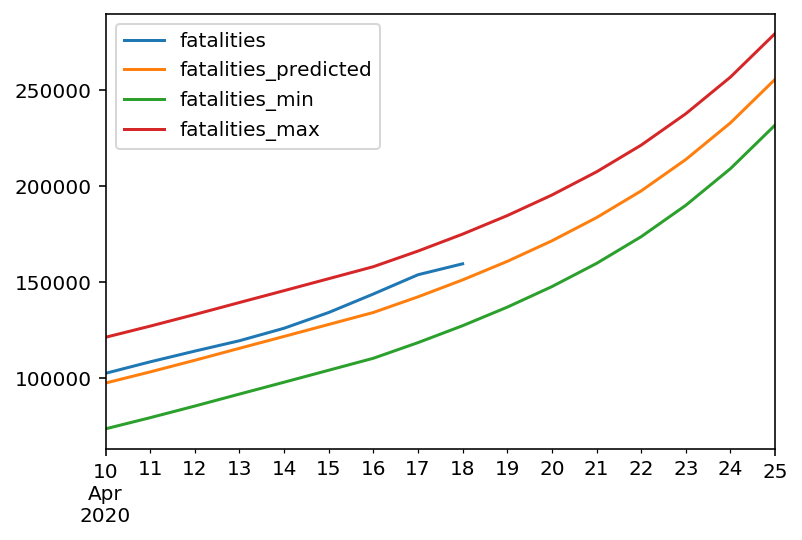

In [166]:
forecast_fatalities.iloc[:,:4].plot()

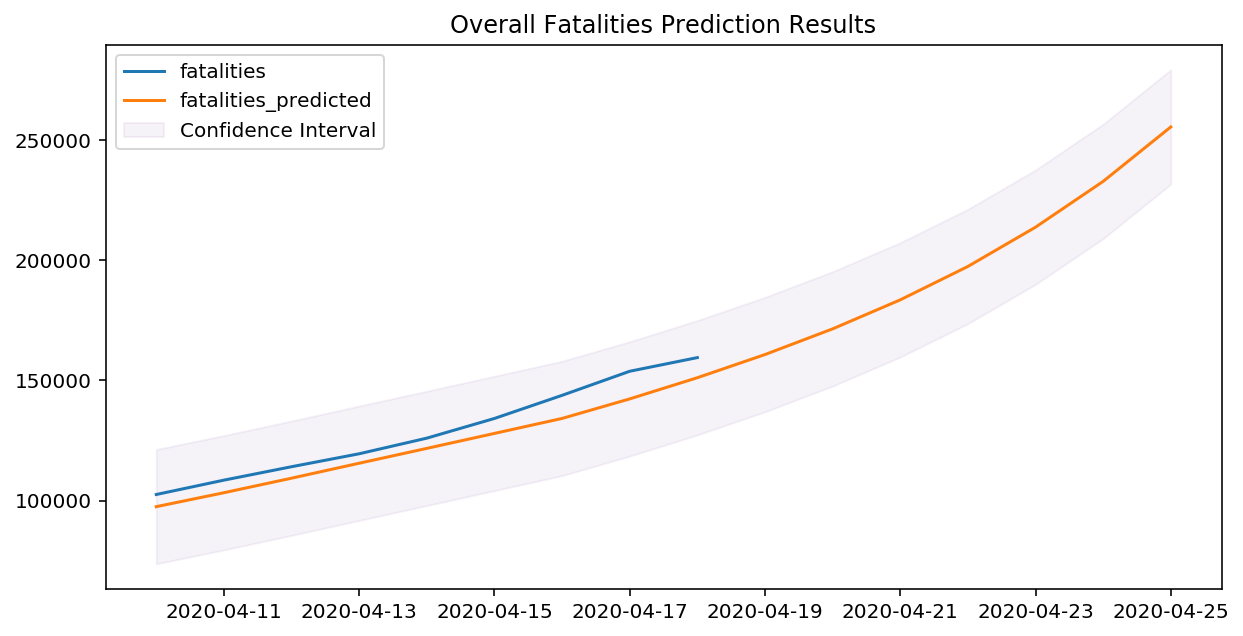

In [167]:
fig= plt.figure(figsize=(10,5))
plt.title("Overall Fatalities Prediction Results")
plt.plot(forecast_fatalities.index,forecast_fatalities["fatalities"],label="fatalities")
plt.plot(forecast_fatalities.index,forecast_fatalities["fatalities_predicted"],label="fatalities_predicted")
#ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.fill_between(forecast_fatalities.index,forecast_fatalities["fatalities_min"],forecast_fatalities["fatalities_max"],color="indigo",alpha=0.05,label="Confidence Interval")
plt.legend()
plt.show()